In [2]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset
import seawater as sw
import cartopy
import cartopy.mpl.geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
def gaussian_windstress(nt=120, end_time=60, max_tau=0.1, sigma=1, center=3.5, angle_up=120.):
    '''nt=120  number of wind records
       end_time = 60  end time of records
       max_tau = 0.1  original 0.1
       sigma = 1 
       center = 3.5  base 3.5 hr, faster 2.5 hr, slower 4.5
       angle_up = 120. Rotation angle (in deg) to get alongshore winds'''
    
    t = np.linspace(0,end_time,nt)  #time array of wind records
    gauss = max_tau*np.exp(-((t-center)**2)/(2*sigma))
    mask = t>center
    gauss[mask]=0
    windstress= gauss.copy()
    #alpha = np.radians(angle_up)
    #zonal_tau = windstress*np.cos(alpha)
    #merid_tau = windstress*np.sin(alpha)
    return(windstress, t)
    

In [4]:
# Base run (winter TS)
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels)

# summer TS run
outdirS = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/04_SVB_augTS_output/'
outdirS2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/04_noSVB_augTS/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
dsS = open_mdsdataset(outdirS, prefix=['eta','dynVars'], levels=levels)
dsS2 = open_mdsdataset(outdirS2, prefix=['eta','dynVars'], levels=levels)

In [5]:
# Get coastline points
df = pd.read_csv('../coastline_points_list.txt',names=['lon_ii','lat_jj'], header=1 )
lon_ii = np.array(df.lon_ii[:])-np.ones_like(df.lon_ii)
lat_jj = np.array(df.lat_jj[:])-np.ones_like(df.lat_jj)

In [6]:
nx = 512
ny = 612
nz = 100
nt = 720

In [7]:
depth = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# No bay centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,nt)*600

# bay centers mask
# centers mask
depthSVB = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)
dep_maskedSVB = np.ma.masked_values(depthSVB,0)
mask_depSVB = np.ma.getmask(dep_maskedSVB)

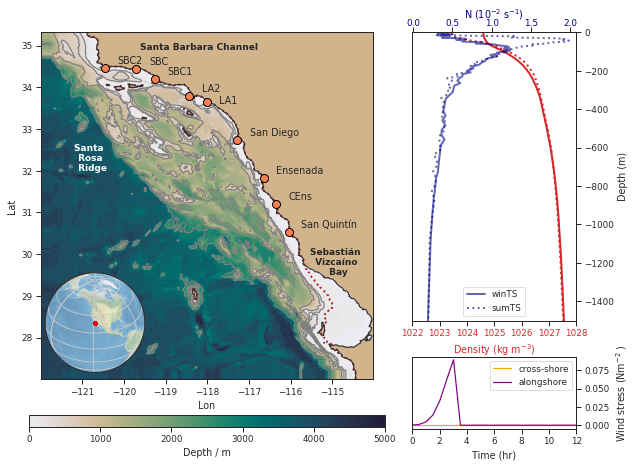

In [15]:
sns.set_style('ticks')
sns.set_context('paper')
fig = plt.figure(figsize=(7.6,5.0))
ax = fig.add_axes([-0.1, -0.15, 0.65, 1.25])
ax.set_facecolor('tan')

pc = ax.pcolormesh(lon,lat,dep_maskedSVB,
                  vmin=0, vmax=5000, cmap=cmo.cm.rain)
cb = plt.colorbar(pc, ax=ax, label='Depth / m',pad=0.08,
                  aspect=30, orientation='horizontal')

cn = ax.contour(lon,lat,dep_maskedSVB, colors=['0.5'], 
                levels=[250,500,1000,2000,3000])

ax.contour(lon,lat,depth[:,:], levels=[0], colors='brown', linestyles=':', linewidths=2)
ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.2')


ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_aspect(1)
    
for kk, lab in zip([47,100,150,230,307,335,400,440,450], 
                   ['San Quintín','CEns' ,'Ensenada','San Diego','LA1','LA2','SBC1','SBC','SBC2']):
    ii = int(lon_ii[kk])
    jj = int(lat_jj[kk])
    
    ax.plot(LON[0,ii],LAT[jj,0],'o', 
            markersize=8, color='coral', markeredgecolor='k')
    if lab == 'LA1':
        ax.text(LON[0,ii]+0.3,LAT[jj,0]-0.05, lab)
    else:
        ax.text(LON[0,ii]+0.3,LAT[jj,0]+0.1, lab)
       
ax.text(0.89,0.3,'Sebastián \n Vizcaíno \n Bay',fontsize=9, fontweight='demibold',horizontalalignment='center',
        transform=ax.transAxes)
#ax.text(0.78,0.41,'San Quintin, BC',fontsize=9, transform=ax.transAxes,fontweight='bold')
#ax.text(0.7,0.55,'Ensenada, BC',fontsize=9, transform=ax.transAxes,fontweight='bold')
#ax.text(0.62,0.67,'Tijuana, BC',fontsize=9, transform=ax.transAxes,fontweight='bold')
#ax.text(0.62,0.7,'San Diego, CA',fontsize=9, transform=ax.transAxes,fontweight='bold')
#ax.text(0.45,0.84,'Santa Monica, CA',fontsize=9, transform=ax.transAxes,fontweight='bold')
#ax.text(0.51,0.8,'Long Beach, CA',fontsize=9, transform=ax.transAxes,fontweight='bold')
ax.text(0.3,0.95,'Santa Barbara Channel',fontsize=9, transform=ax.transAxes,
        fontweight='demibold')
ax.text(0.15,0.6,'Santa \n Rosa \n Ridge',color='w',fontsize=9, transform=ax.transAxes,
        fontweight='bold', horizontalalignment='center')

#---- Plot globe -------------------------
axins = inset_axes(ax, width="30%", height="30%", loc= 'lower left',
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.Orthographic(central_latitude=32, 
                                                                            central_longitude=-118)))
axins.add_feature(cartopy.feature.OCEAN, zorder=0)
axins.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
axins.gridlines()
axins.stock_img()
#axins.plot([lon[0]+360], [lat[0]],'ro', transform=cartopy.crs.Orthographic(-110, 35))
#axins.plot([ lon[-1]+360], [lat[-1]],'ro', transform=cartopy.crs.Orthographic(-120, 35))
axins.plot(lon, np.ones_like(lon)*27,'r.',transform=cartopy.crs.Orthographic(-118, 32))
axins.plot(lon, np.ones_like(lon)*35.3,'r.',transform=cartopy.crs.Orthographic(-118, 32))

# ------------- N and rho ---------------------------
ax2 = fig.add_axes([0.6, 0., 0.3, 0.2])
tau_along, t = gaussian_windstress()
ax2.plot(t,np.zeros_like(t), color='orange', label='cross-shore')
ax2.plot(t,tau_along, color='purple', label='alongshore')
ax2.set_xlabel('Time (hr)')
ax2.set_ylabel(r'Wind stress (Nm$^{-2}$ )')
ax2.yaxis.set_label_position("right")
ax2.set_xlim([0,12])
ax2.yaxis.tick_right()
ax2.legend()


pden_feb = sw.pden(ds.SALT[0,:,100,100].data,ds.THETA[0,:,100,100].data,-ds.Z.data)
N2_feb,q,pave_feb  = sw.bfrq(ds.SALT[0,:,100,100].data,ds.THETA[0,:,100,100].data,-ds.Z.data)

pden_aug = sw.pden(dsS.SALT[0,:,100,100].data,dsS.THETA[0,:,100,100].data,-dsS.Z.data)
N2_aug,q,pave_aug  = sw.bfrq(dsS.SALT[0,:,100,100].data,dsS.THETA[0,:,100,100].data,-dsS.Z.data)

ax3 = fig.add_axes([0.6, 0.3, 0.3, 0.8])
color = 'tab:red'
ax3.set_ylabel('Depth (m)')
ax3.set_xlabel(r'Density (kg m$^{-3}$)',color=color)
ax3.plot(pden_feb,ds.Z.data,'-', color=color, label='winTS', alpha=1, linewidth=2)
ax3.plot(pden_aug,dsS.Z.data,':', color=color, label='sumTS', alpha=1, linewidth=2)

ax3.tick_params(axis='x', labelcolor=color)
ax3.set_ylim(-3000,0)
ax3.set_xlim(1022, 1028)
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax4 = ax3.twiny() 
color = 'navy'
ax4.set_xlabel(r'N (10$^{-2}$ s$^{-1}$)', color=color, labelpad=0.5)
ax4.plot(100*np.sqrt(N2_feb),-pave_feb,'-', color=color, label='winTS', alpha=0.6, linewidth=2)
ax4.plot(100*np.sqrt(N2_aug),-pave_aug,':', color=color, label='sumTS', alpha=0.6, linewidth=2)
ax4.tick_params(axis='x', labelcolor=color, pad=0)
ax4.set_ylim(-1500,0)
ax4.legend(loc=8)
plt.savefig('figure1.png', dpi=500, bbox_inches='tight')

Text(0.22, 0.92, 'Canal de Santa Bárbara')

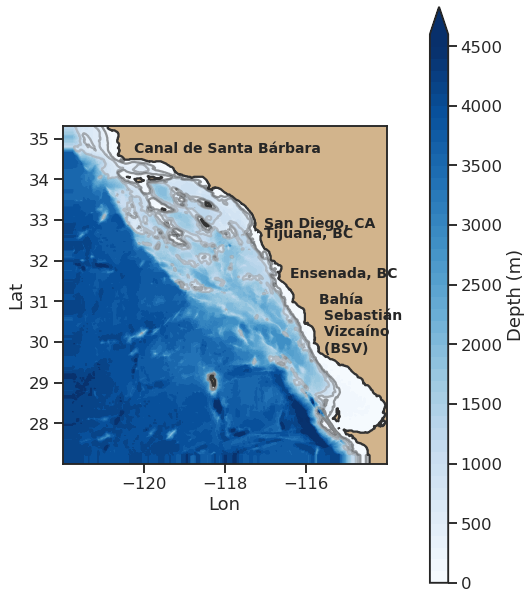

In [9]:
sns.set_style('ticks')
sns.set_context('talk')
fig = plt.figure(figsize=(8,10))

ax = fig.add_axes([0.1, 0.0, 0.75, 0.8])
ax.set_facecolor('tan')

pc = ax.contourf(lon,lat,dep_maskedSVB, 50,
                  vmin=0,vmax=4500,  cmap='Blues', extend='max')
cb = plt.colorbar(pc, ax=ax, label='Depth (m)',pad=0.1, aspect=30)

cn = ax.contour(lon,lat,dep_maskedSVB, alpha=0.5, 
                levels=[200,500,1000], colors=['0.2','0.4','0.6'])

ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.2')

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

ax.set_aspect(1)

ax.text(0.79,0.33,'Bahía \n Sebastián \n Vizcaíno \n (BSV)',fontsize=14, fontweight='bold',
        transform=ax.transAxes)
#ax.text(0.78,0.41,'San Quintin, BC',fontsize=12, transform=ax.transAxes,fontweight='bold')
ax.text(0.7,0.55,'Ensenada, BC',fontsize=14, transform=ax.transAxes,fontweight='bold')
ax.text(0.62,0.67,'Tijuana, BC',fontsize=14, transform=ax.transAxes,fontweight='bold')
ax.text(0.62,0.7,'San Diego, CA',fontsize=14, transform=ax.transAxes,fontweight='bold')
#ax.text(0.45,0.84,'Santa Monica, CA',fontsize=12, transform=ax.transAxes,fontweight='bold')
ax.text(0.22,0.92,'Canal de Santa Bárbara',fontsize=14, transform=ax.transAxes,
        fontweight='bold')


In [10]:
print('%f' %lon[0])

-121.992200


In [11]:
-121.99 + 360

238.01

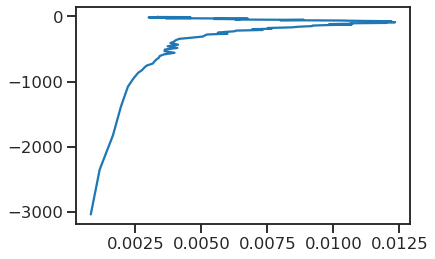

In [12]:
plt.plot(np.sqrt(N2_feb),-pave_feb)


In [13]:
N2_feb

array([[ 1.11747885e-05],
       [ 1.11788735e-05],
       [ 1.11829436e-05],
       [ 2.09568186e-05],
       [ 9.75859686e-06],
       [ 9.00081491e-06],
       [ 1.63624795e-05],
       [ 1.52534293e-05],
       [ 2.12425843e-05],
       [ 1.32320099e-05],
       [ 2.98747630e-05],
       [ 4.56180305e-05],
       [ 2.99712929e-05],
       [ 4.17968411e-05],
       [ 3.95524683e-05],
       [ 7.87971397e-05],
       [ 6.37190119e-05],
       [ 1.05116952e-04],
       [ 1.18773839e-04],
       [ 1.43711127e-04],
       [ 1.48879245e-04],
       [ 1.33925003e-04],
       [ 1.52176241e-04],
       [ 1.32425776e-04],
       [ 1.44000005e-04],
       [ 1.13467914e-04],
       [ 1.14881559e-04],
       [ 9.67980031e-05],
       [ 1.14181289e-04],
       [ 9.59241546e-05],
       [ 8.47400965e-05],
       [ 8.44773814e-05],
       [ 7.52890362e-05],
       [ 7.08265999e-05],
       [ 5.64302858e-05],
       [ 5.87365944e-05],
       [ 4.78686729e-05],
       [ 5.35468241e-05],
       [ 3.9